In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
from matplotlib.axis import Axis
import datetime as dt

import time
start = time.time()

In [2]:
def get_data2(filename):    
    data = pd.read_csv(filename) #, names=["Interval","kWh"])
    return data
    
def conso_byhour(day):
    ''' 
    display conso by hour for the chosen day
    '''
    conso_day=conso_data[conso_data['days']==day].copy()  # no more error
    conso_day['heure']=conso_day['dates'].apply(lambda x: str(x.hour)+':'+str(x.minute) +':'+str(x.second))

    conso_hours = conso_day.copy()
    conso_hours['hours']= conso_hours['dates'].dt.strftime('%H')
    conso_hours#.info()
    # group by hour
    groupedbyhour = conso_hours[['hours','kWh']].groupby('hours', sort=False)
    groupedbyhour.count()
    len(groupedbyhour)
    x = np.arange(1,len(groupedbyhour)+1)

    #groupedbyhour.count().plot(grid=True,xticks=x)
    plt.figure(figsize=(12, 8),facecolor='darkcyan')
    values = groupedbyhour.count().kWh
    #ax = plt.bar(x,groupedbyhour.count().kWh)
    ax = values.plot(kind="bar",color='green',width=.8)
    ax.set_facecolor('antiquewhite')
    #plt.grid()
    plt.tight_layout()
    plt.title(f'Conso by hour (W) - {day}')
    plt.xlim(-1,len(x)+1)
    plt.xticks(rotation=30);
    
    rects = ax.patches

    # Make some labels.
    labels = [f"{i}" for i in values]
    
    for rect, label in zip(rects, labels):
        height = rect.get_height()
        ax.text(
            rect.get_x() + rect.get_width() / 2, height + 5, label, ha="center", va="bottom",
            fontfamily='calibri', fontsize=16, fontweight='bold', color='blue'
        )
    
    
def from_csv(csv_file): 
    ''' save data to csv  '''
    df = pd.read_csv(csv_file)
    return df
    
def to_csv(csv_file, df):
    ''' read data from csv'''
    df.to_csv(csv_file, index=False)


### conso.csv créé par pi4 node-red onglet Linky
#### création de conso_data 

In [3]:
conso_file = r"\\192.168.0.175\pihome\Documents\conso2.csv"
conso_data = get_data2(conso_file)
conso_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2030158 entries, 0 to 2030157
Data columns (total 2 columns):
 #   Column    Dtype  
---  ------    -----  
 0   Interval  int64  
 1   kWh       float64
dtypes: float64(1), int64(1)
memory usage: 31.0 MB


### conversion Interval -> kWh

In [4]:
conso_data['sec']=conso_data['Interval']/1000


In [5]:
conso_data['Wh']=3600000/conso_data['Interval']


### Cumul Total interval

In [6]:
conso_data['cumul(ms)']=conso_data['Interval'].cumsum(axis=0)

In [7]:
l=len(conso_data)-1

cumtime= int(conso_data._get_value(l,'cumul(ms)')*1000)  # convert to microseconds
cumtime

49678486925000

### Calcul de la date de base = now - cumul_interval

In [8]:
from datetime import datetime, timedelta
now = datetime.now()
# conso.csv dynamique
base = now - timedelta(microseconds=cumtime)
base  # date de début

datetime.datetime(2023, 8, 21, 21, 38, 27, 700217)

In [9]:
conso_data['cumul(ms)'][conso_data['cumul(ms)'].isna()==True]

Series([], Name: cumul(ms), dtype: int64)

In [10]:
conso_data.iloc[0]


Interval     21934.00000
kWh              0.16000
sec             21.93400
Wh             164.12875
cumul(ms)    21934.00000
Name: 0, dtype: float64

### Recréer les dates à partir des cumuls par impulsion


In [11]:
base

datetime.datetime(2023, 8, 21, 21, 38, 27, 700217)

## créer les dates

In [12]:
# create column 'dates' with time cumulated time from base
conso_data['dates'] = [base + dt.timedelta(microseconds=t*1000) for t in conso_data['cumul(ms)']]
conso_data['dates']

0         2023-08-21 21:38:49.634217
1         2023-08-21 21:39:11.492217
2         2023-08-21 21:39:33.493217
3         2023-08-21 21:39:55.421217
4         2023-08-21 21:40:17.312217
                     ...            
2030153   2025-03-18 21:11:50.432217
2030154   2025-03-18 21:12:11.320217
2030155   2025-03-18 21:12:32.352217
2030156   2025-03-18 21:12:53.470217
2030157   2025-03-18 21:13:14.625217
Name: dates, Length: 2030158, dtype: datetime64[ns]

### create column 'days' avec format 'dd/mm/yy'


In [13]:
conso_data['days']= [d.strftime('%d/%m/%y') for d in conso_data['dates']]    
#[str(d.month)+'-'+str(d.day) for d in conso_data['dates']]
conso_data

,Interval,kWh,sec,Wh,cumul(ms),dates,days
0,21934,0.16,21.934,164.128750,21934,2023-08-21 21:38:49.634217,21/08/23
1,21858,0.16,21.858,164.699424,43792,2023-08-21 21:39:11.492217,21/08/23
2,22001,0.16,22.001,163.628926,65793,2023-08-21 21:39:33.493217,21/08/23
3,21928,0.16,21.928,164.173659,87721,2023-08-21 21:39:55.421217,21/08/23
4,21891,0.16,21.891,164.451144,109612,2023-08-21 21:40:17.312217,21/08/23
...,...,...,...,...,...,...,...
2030153,21066,0.17,21.066,170.891484,49678402732,2025-03-18 21:11:50.432217,18/03/25
2030154,20888,0.17,20.888,172.347759,49678423620,2025-03-18 21:12:11.320217,18/03/25
2030155,21032,0.17,21.032,171.167744,49678444652,2025-03-18 21:12:32.352217,18/03/25
2030156,21118,0.17,21.118,170.470689,49678465770,2025-03-18 21:12:53.470217,18/03/25


### save conso_data with dates

In [14]:
#to_csv(r'../conso_data_with_dates.csv',conso_data)

# tranche journalière


In [15]:
now = datetime.now()
month = now.month
year = now.year
date = now.day
today = now.strftime('%d/%m/%y')    #str(now.month)+'-'+str(now.day)
today, date, month, year


('18/03/25', 18, 3, 2025)

In [16]:
here = now.strftime('%H:%M:%S')
here

'21:13:54'

In [17]:
conso_day = conso_data[conso_data['days']==today]
# save to file
filename='conso_jour.csv'
conso_day.to_csv(filename)
filename='../conso_jour.csv'
conso_day.to_csv(filename)

In [18]:
conso_day.info()


<class 'pandas.core.frame.DataFrame'>
Index: 2986 entries, 2027172 to 2030157
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Interval   2986 non-null   int64         
 1   kWh        2986 non-null   float64       
 2   sec        2986 non-null   float64       
 3   Wh         2986 non-null   float64       
 4   cumul(ms)  2986 non-null   int64         
 5   dates      2986 non-null   datetime64[ns]
 6   days       2986 non-null   object        
dtypes: datetime64[ns](1), float64(3), int64(2), object(1)
memory usage: 186.6+ KB


In [19]:
end = time.time()
print(end - start)

42.006898403167725


### grouped by days

In [20]:
# group by day
grouped = conso_data[['days','kWh']].groupby('days', sort=False)
'''conso_graph=[]
for name, group in grouped:
    if name=='01/04/2024':print(group)
    #print("\n", name, len(group)/1000)
    conso_graph.append((name,len(group)/1000))'''
#grouped
# count elements in each group => conso in watts => convert to kW
df_grp = grouped.count()/1000



In [21]:
data = list(df_grp['kWh'])
print(data)

[0.499, 3.699, 4.243, 3.687, 3.911, 4.57, 3.78, 3.464, 3.511, 3.699, 3.341, 4.226, 4.16, 3.738, 3.621, 3.637, 3.318, 3.377, 4.06, 4.011, 3.996, 4.138, 3.521, 4.19, 4.01, 3.747, 4.072, 4.58, 4.215, 3.221, 3.166, 3.855, 3.816, 3.077, 3.77, 4.142, 3.639, 3.735, 4.555, 4.322, 4.416, 3.901, 3.446, 4.256, 3.944, 3.738, 3.581, 3.929, 3.761, 3.482, 4.087, 3.404, 3.816, 3.902, 3.59, 3.706, 4.364, 3.243, 3.882, 3.193, 2.055, 2.042, 2.257, 4.091, 3.621, 4.313, 3.62, 4.001, 3.785, 3.693, 4.182, 3.974, 3.825, 3.145, 3.737, 3.596, 3.54, 3.637, 3.754, 3.346, 3.773, 3.282, 3.749, 3.599, 4.06, 3.583, 3.554, 3.648, 4.044, 4.404, 3.934, 4.061, 4.336, 3.845, 3.861, 3.802, 3.801, 3.831, 4.061, 4.44, 3.819, 3.544, 3.68, 3.688, 3.34, 3.839, 3.791, 4.308, 3.528, 4.164, 3.536, 3.923, 4.707, 3.574, 3.616, 3.499, 3.948, 3.901, 4.145, 3.844, 3.835, 3.637, 4.956, 3.861, 3.679, 4.202, 4.274, 4.284, 4.573, 4.153, 3.667, 4.45, 4.696, 4.094, 4.724, 4.529, 3.676, 4.01, 3.952, 3.617, 3.564, 3.958, 3.651, 3.707, 3.639, 3

In [22]:
# save to file
import pickle
path = r'kwh_mean.pkl'
with open(path,'wb') as file:
    pickle.dump(data, file)

In [23]:
end = time.time()
print(end - start)

42.71500325202942


### plot function by day
#### show('dd/mm/yy')

In [24]:
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
def show(day,pltcolor='darkcyan',bgcolor="ivory"):
    conso_day=conso_data[conso_data['days']==day].copy()  # no more error
    conso_day['heure']=conso_day['dates'].apply(lambda x: str(x.hour)+':'+str(x.minute) +':'+str(x.second))
    #=[x.hour for x in conso_day['dates']]
    #print(conso_day)
    df = conso_day.set_index('heure')
    here = now.strftime('%H:%M:%S')
    conso_jour=len(df['kWh'])
    here, len(df)/1000, conso_jour

    # consommation d'une journée entière à partir de minuit
    # Set background color of the outer 
    # area of the plt
    #plt.figure(facecolor=fgcolor)
    fig, ax = plt.subplots(facecolor=pltcolor)
    
    major_ticks=300;minor_ticks=100
    ax.xaxis.set_major_locator(MultipleLocator(major_ticks))  # major ticks tous les 15 min
    ax.xaxis.set_minor_locator(MultipleLocator(minor_ticks))
    # the size of A4 paper
    fig.set_size_inches(10, 5)
    
    # set bg color
    ax.set_facecolor(bgcolor)
    plt.plot(df['kWh'])
    #plt.plot(conso_day['heure'],conso_day['kWh'])
    plt.title(f'Journée du {day} {here} : {conso_jour/1000} kwh')
    plt.grid()
    plt.xticks(rotation=30);


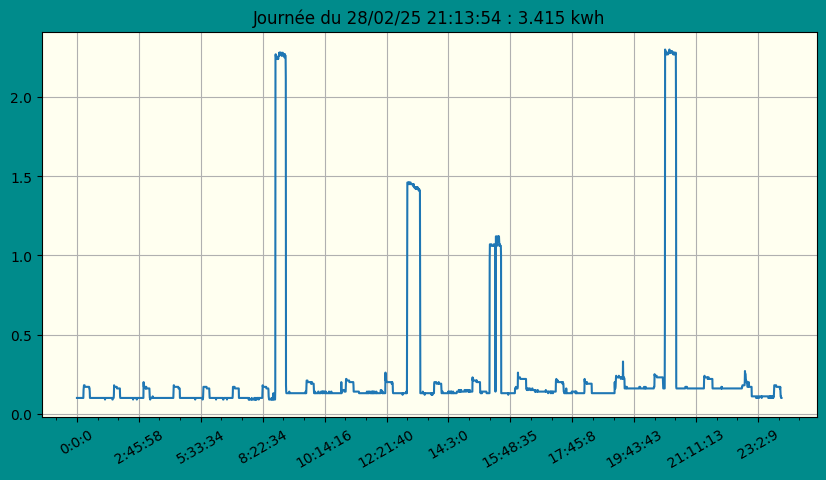

In [25]:
show('28/02/25')

In [26]:
end = time.time()
print(end - start)

44.72599816322327


### 1 kWh window in data of one day
#### df = conso_day

In [27]:
df = conso_day
df

,Interval,kWh,sec,Wh,cumul(ms),dates,days
2027172,17709,0.20,17.709,203.286465,49602104752,2025-03-18 00:00:12.452217,18/03/25
2027173,19205,0.19,19.205,187.451185,49602123957,2025-03-18 00:00:31.657217,18/03/25
2027174,25482,0.14,25.482,141.276195,49602149439,2025-03-18 00:00:57.139217,18/03/25
2027175,25360,0.14,25.360,141.955836,49602174799,2025-03-18 00:01:22.499217,18/03/25
2027176,25676,0.14,25.676,140.208755,49602200475,2025-03-18 00:01:48.175217,18/03/25
...,...,...,...,...,...,...,...
2030153,21066,0.17,21.066,170.891484,49678402732,2025-03-18 21:11:50.432217,18/03/25
2030154,20888,0.17,20.888,172.347759,49678423620,2025-03-18 21:12:11.320217,18/03/25
2030155,21032,0.17,21.032,171.167744,49678444652,2025-03-18 21:12:32.352217,18/03/25
2030156,21118,0.17,21.118,170.470689,49678465770,2025-03-18 21:12:53.470217,18/03/25


In [28]:

def period(df=df, p=1):
    ''' 
    give the time of conso for a 1kWh window in a day
    p =  ordinal window ex: p=1 first kWh, p=2 second kWh ..
    df is the data from midnight, each entry is 1 watt
    as the length of df is the total conso in watt,
    we have len(df)/1000 = number of windows of 1 KWh since midnight
    the last window may not be 1000 watt long !
    '''
    if p==1:
        start = df.iloc[0].dates
    else:
        start = df.iloc[(p-1)*1000-1].dates
    if len(df)>p*1000:
        end = df.iloc[p*1000-1].dates
        conso = p*1000
    else:
        end = df.iloc[len(df)-1].dates
        conso = len(df) - (p-1)*1000
    period = end - start  # type timedelta
    hours = int(period / dt.timedelta(hours=1))
    mins = int(period / dt.timedelta(minutes=1)) - hours*60
    secs = int(period / dt.timedelta(seconds=1)) - hours*3600 - mins*60

    #df.iloc[1001:2000]['dates']#.tail(1)
    #print(period)
    print(f'{start}\t{end}\t{hours}h {mins}m {secs}s \t{conso}')


In [29]:
df = conso_day
len(df)

2986

In [30]:
period()  # first kWh

2025-03-18 00:00:12.452217	2025-03-18 08:49:56.981217	8h 49m 44s 	1000


In [31]:
period(p=2) # second period

2025-03-18 08:49:56.981217	2025-03-18 14:10:21.437217	5h 20m 24s 	2000


In [32]:
# mean of all instant conso
total_mean = conso_data[['kWh']].mean()
total_mean

kWh    0.301727
dtype: float64

In [33]:
end = time.time()
print(end - start)

45.42707705497742


## mean for data grouped by days

In [34]:
mean=(grouped.count()/1000).mean()
mean

kWh    3.52458
dtype: float64

In [35]:
last=df_grp.iloc[-1]['kWh']
last

2.986

# conso by date


In [36]:
# select day
day = today

#day = '16/08/24'
day

'18/03/25'

In [37]:
df

,Interval,kWh,sec,Wh,cumul(ms),dates,days
2027172,17709,0.20,17.709,203.286465,49602104752,2025-03-18 00:00:12.452217,18/03/25
2027173,19205,0.19,19.205,187.451185,49602123957,2025-03-18 00:00:31.657217,18/03/25
2027174,25482,0.14,25.482,141.276195,49602149439,2025-03-18 00:00:57.139217,18/03/25
2027175,25360,0.14,25.360,141.955836,49602174799,2025-03-18 00:01:22.499217,18/03/25
2027176,25676,0.14,25.676,140.208755,49602200475,2025-03-18 00:01:48.175217,18/03/25
...,...,...,...,...,...,...,...
2030153,21066,0.17,21.066,170.891484,49678402732,2025-03-18 21:11:50.432217,18/03/25
2030154,20888,0.17,20.888,172.347759,49678423620,2025-03-18 21:12:11.320217,18/03/25
2030155,21032,0.17,21.032,171.167744,49678444652,2025-03-18 21:12:32.352217,18/03/25
2030156,21118,0.17,21.118,170.470689,49678465770,2025-03-18 21:12:53.470217,18/03/25


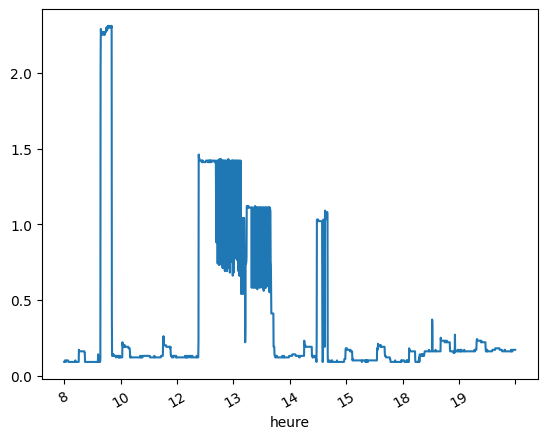

In [38]:
conso_day=conso_data[conso_data['days']==day].copy()  # no more error
conso_day['heure']=conso_day['dates'].apply(lambda x: str(x.hour)) #+':'+str(x.minute) +':'+str(x.second))
#=[x.hour for x in conso_day['dates']]
df= conso_day.set_index('heure')
df.tail(2000)['kWh'].plot()
plt.xticks(rotation=30);
#conso_day['heure']


In [39]:
end = time.time()
print(end - start)

46.40448522567749


### grouped by 'heure'

In [40]:
conso_day.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2986 entries, 2027172 to 2030157
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Interval   2986 non-null   int64         
 1   kWh        2986 non-null   float64       
 2   sec        2986 non-null   float64       
 3   Wh         2986 non-null   float64       
 4   cumul(ms)  2986 non-null   int64         
 5   dates      2986 non-null   datetime64[ns]
 6   days       2986 non-null   object        
 7   heure      2986 non-null   object        
dtypes: datetime64[ns](1), float64(3), int64(2), object(2)
memory usage: 210.0+ KB


In [41]:
df

,Interval,kWh,sec,Wh,cumul(ms),dates,days
heure,,,,,,,
0,17709,0.20,17.709,203.286465,49602104752,2025-03-18 00:00:12.452217,18/03/25
0,19205,0.19,19.205,187.451185,49602123957,2025-03-18 00:00:31.657217,18/03/25
0,25482,0.14,25.482,141.276195,49602149439,2025-03-18 00:00:57.139217,18/03/25
0,25360,0.14,25.360,141.955836,49602174799,2025-03-18 00:01:22.499217,18/03/25
0,25676,0.14,25.676,140.208755,49602200475,2025-03-18 00:01:48.175217,18/03/25
...,...,...,...,...,...,...,...
21,21066,0.17,21.066,170.891484,49678402732,2025-03-18 21:11:50.432217,18/03/25
21,20888,0.17,20.888,172.347759,49678423620,2025-03-18 21:12:11.320217,18/03/25
21,21032,0.17,21.032,171.167744,49678444652,2025-03-18 21:12:32.352217,18/03/25


In [42]:
# group by hour, df  = data of a chosen day
df_byhour = df[['days','kWh']].groupby('heure', sort=False)
df_byhour.groups

{'0': ['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', ...], '1': ['1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '

In [43]:
kwh_byhour = df_byhour['kWh']
kwh_byhour.count()

heure
0     142
1     125
2     122
3     113
4     101
5     107
6     107
7      93
8     105
9     105
10    177
11    125
12    137
13    418
14    178
15    108
16     99
17    118
18    119
19    174
20    176
21     37
Name: kWh, dtype: int64

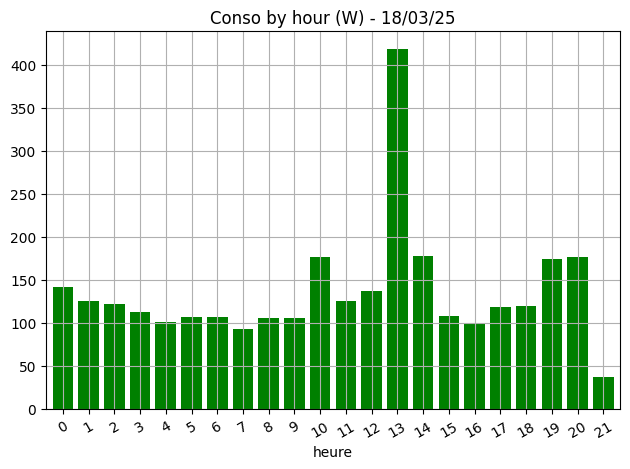

In [44]:
kwh_byhour.count().plot(grid=True, kind='bar',color='green',width=.8)
plt.title(f'Conso by hour (W) - {day}')
plt.xticks(rotation=30);
plt.tight_layout()

In [45]:
df_grp.info()

<class 'pandas.core.frame.DataFrame'>
Index: 576 entries, 21/08/23 to 18/03/25
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   kWh     576 non-null    float64
dtypes: float64(1)
memory usage: 9.0+ KB


In [46]:
# give the periods of 1 kwh in a day
period()

2025-03-18 00:00:12.452217	2025-03-18 08:49:56.981217	8h 49m 44s 	1000


In [47]:

# premier kWh
if len(df)>1000:
    df.iloc[1000]['dates']
df.iloc[0].dates, df.iloc[1000].dates
#df.dates.dt.time


(Timestamp('2025-03-18 00:00:12.452217'),
 Timestamp('2025-03-18 08:50:33.862217'))

In [48]:

# save data
# df_grp.to_csv('df_grp.csv')
# df.to_csv('df.csv')
df_grp.to_csv('conso_day_from_20230821.csv')

#df.info()
#df_grp


In [49]:
df_grp.mean()


kWh    3.52458
dtype: float64

In [50]:
df_grp.head()


,kWh
days,
21/08/23,0.499
22/08/23,3.699
23/08/23,4.243
24/08/23,3.687
25/08/23,3.911


In [51]:
df_grp.tail()


,kWh
days,
14/03/25,3.396
15/03/25,3.896
16/03/25,3.099
17/03/25,3.082
18/03/25,2.986


In [52]:
end = time.time()
print(end - start)

48.03520202636719


# plot les 100 derniers jours


In [53]:
# moyenne sur 100 jours
df_grp.tail(100).mean()


kWh    3.68534
dtype: float64

Text(0.5, 1.0, 'Conso (kWh) last 100 days')

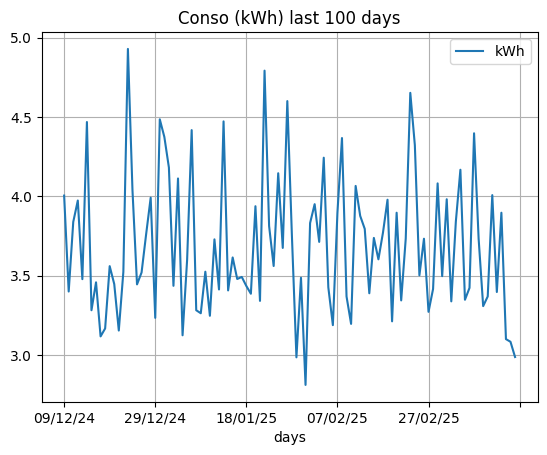

In [54]:
# plot last 100 days
df_100 = df_grp.tail(100)
df_100.plot()
plt.grid()
plt.title('Conso (kWh) last 100 days')


In [55]:
# max min during last 100 days
df_100.describe().loc[['min','max']]


,kWh
min,2.810
max,4.929


In [56]:
end = time.time()
print(end - start)

48.772682428359985


Text(0.5, 1.0, 'Last month conso by day')

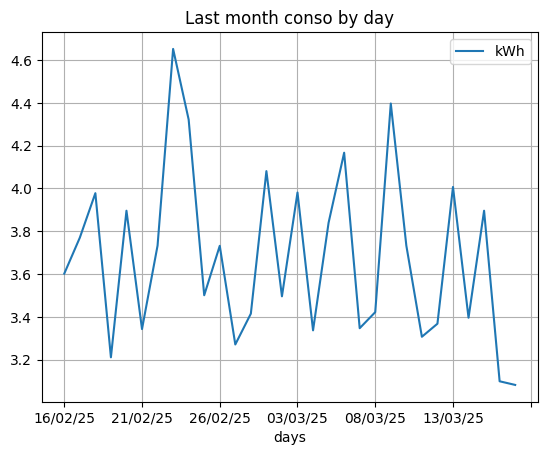

In [57]:
# plot last monthh
df_grp.iloc[-31:-1].plot()
plt.grid()
plt.title('Last month conso by day')


In [58]:
month = df_grp.iloc[-31:-1]['kWh']
print('Max :',month.idxmax(), max(month))
print('Min :',month.idxmin(), min(month))

Max : 23/02/25 4.652
Min : 17/03/25 3.082


In [59]:

tranches = len(df)//1000
tranches+1


3

In [60]:
# temps de conso par tranches de 1kwh
for p in range(1,tranches+2):  # les 5 tranches de kWh consommés
    if len(df)>(p-1)*1000:
        period(p=p)
# conso temps réel
here = now.strftime('%H:%M:%S')
conso_jour=len(df['kWh'])
here, len(df)/1000, conso_jour


2025-03-18 00:00:12.452217	2025-03-18 08:49:56.981217	8h 49m 44s 	1000
2025-03-18 08:49:56.981217	2025-03-18 14:10:21.437217	5h 20m 24s 	2000
2025-03-18 14:10:21.437217	2025-03-18 21:13:14.625217	7h 2m 53s 	986


('21:13:54', 2.986, 2986)

In [61]:
#add hours column for a chosen day
conso_hours = conso_day.copy()
conso_hours['hours']= conso_hours['dates'].dt.strftime('%H')
conso_hours.info()


<class 'pandas.core.frame.DataFrame'>
Index: 2986 entries, 2027172 to 2030157
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Interval   2986 non-null   int64         
 1   kWh        2986 non-null   float64       
 2   sec        2986 non-null   float64       
 3   Wh         2986 non-null   float64       
 4   cumul(ms)  2986 non-null   int64         
 5   dates      2986 non-null   datetime64[ns]
 6   days       2986 non-null   object        
 7   heure      2986 non-null   object        
 8   hours      2986 non-null   object        
dtypes: datetime64[ns](1), float64(3), int64(2), object(3)
memory usage: 233.3+ KB


In [62]:
conso_hours['heure'], conso_hours['hours']

(2027172     0
 2027173     0
 2027174     0
 2027175     0
 2027176     0
            ..
 2030153    21
 2030154    21
 2030155    21
 2030156    21
 2030157    21
 Name: heure, Length: 2986, dtype: object,
 2027172    00
 2027173    00
 2027174    00
 2027175    00
 2027176    00
            ..
 2030153    21
 2030154    21
 2030155    21
 2030156    21
 2030157    21
 Name: hours, Length: 2986, dtype: object)

In [63]:
end = time.time()
print(end - start)

49.81579923629761


# select number of days to display


In [64]:
span = 30
#df_grp.tail(span)

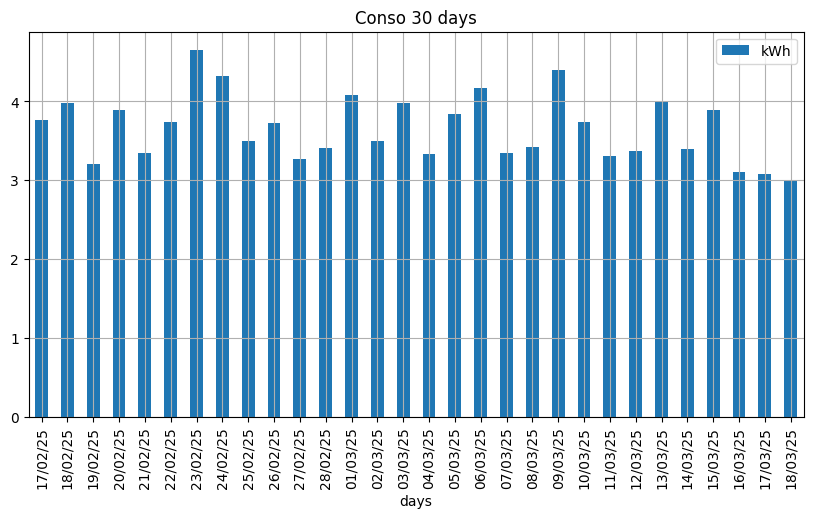

In [65]:

# Plot the figure without labels
df_grp.tail(span).plot.bar(grid=True, figsize=(10, 5), layout='tight') 
plt.title(f'Conso {span} days')
plt.xticks(rotation=90);


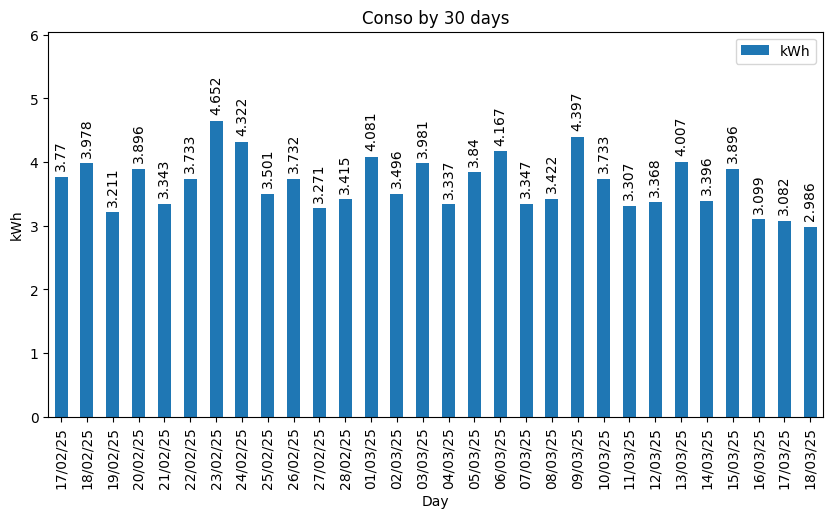

In [66]:
# Plot the figure with labels.
x_labels = list(df_grp.tail(span)['kWh'])
#x_labels
#fig, ax = plt.subplots(figsize=(2, 2), facecolor='lightskyblue',layout='constrained')
ax = df_grp.tail(span).plot(kind="bar", figsize=(10, 5), layout='tight')
ax.set_title(f"Conso by {span} days")
ax.set_xlabel("Day")
ax.set_ylabel("kWh")
ax.set_ymargin(0.3)
#ax.set_xticklabels(x_labels)
#fig.tight_layout()

rects = ax.patches

# Make some labels.
labels = [x_labels[i] for i in range(len(x_labels))]

for rect, label in zip(rects, labels):
    height = rect.get_height()
    #print(height)
    ax.text(
        rect.get_x() + rect.get_width() / 2, height+.1, label, ha="center", va="bottom", rotation=90
    )

#plt.show()

In [67]:
y_labels = df_grp.tail(span)['kWh']
y_labels

days
17/02/25    3.770
18/02/25    3.978
19/02/25    3.211
20/02/25    3.896
21/02/25    3.343
22/02/25    3.733
23/02/25    4.652
24/02/25    4.322
25/02/25    3.501
26/02/25    3.732
27/02/25    3.271
28/02/25    3.415
01/03/25    4.081
02/03/25    3.496
03/03/25    3.981
04/03/25    3.337
05/03/25    3.840
06/03/25    4.167
07/03/25    3.347
08/03/25    3.422
09/03/25    4.397
10/03/25    3.733
11/03/25    3.307
12/03/25    3.368
13/03/25    4.007
14/03/25    3.396
15/03/25    3.896
16/03/25    3.099
17/03/25    3.082
18/03/25    2.986
Name: kWh, dtype: float64

In [68]:
x_labels=df_grp.tail(span).index
x_labels

Index(['17/02/25', '18/02/25', '19/02/25', '20/02/25', '21/02/25', '22/02/25',
       '23/02/25', '24/02/25', '25/02/25', '26/02/25', '27/02/25', '28/02/25',
       '01/03/25', '02/03/25', '03/03/25', '04/03/25', '05/03/25', '06/03/25',
       '07/03/25', '08/03/25', '09/03/25', '10/03/25', '11/03/25', '12/03/25',
       '13/03/25', '14/03/25', '15/03/25', '16/03/25', '17/03/25', '18/03/25'],
      dtype='object', name='days')

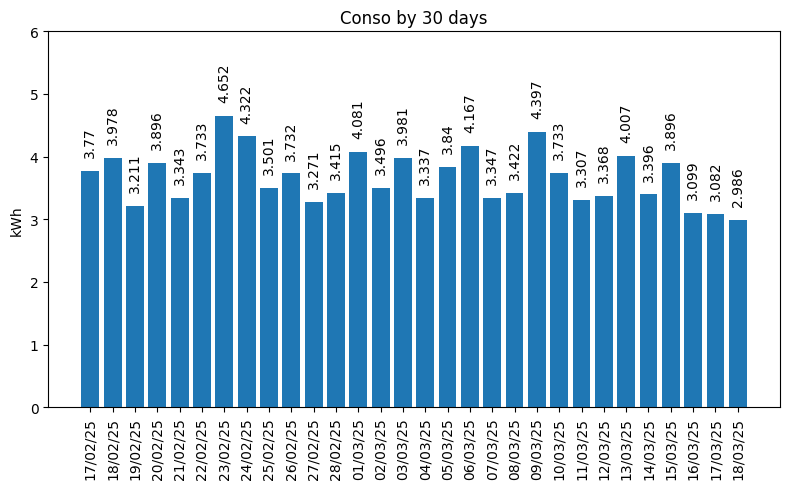

In [69]:
# Plot the figure with labels
# using bar_label
# https://matplotlib.org/stable/gallery/lines_bars_and_markers/bar_label_demo.html#sphx-glr-gallery-lines-bars-and-markers-bar-label-demo-py
fig, ax = plt.subplots(figsize=(8, 5), layout='tight')
bar_container = ax.bar(x_labels, y_labels)
#ax.set_xticks(x_labels, rotation=45)
ax.bar_label(bar_container, rotation=90, padding=10) #, fmt='{:,.0f}')
ax.set(ylabel='kWh', title=f'Conso by {span} days', ylim=(0, 6))
plt.xticks(rotation=90);


In [70]:
end = time.time()
print(end - start)

54.95585918426514


In [71]:
# figure manager

current=plt.get_current_fig_manager()
current.set_window_title('Conso by day')
#help(current.canvas)
#,facecolor='darkcyan')
#plt.style.use('fivethirtyeight')
#plt.style.use('ggplot')
#plt.style.use('dark_background')


<Figure size 640x480 with 0 Axes>

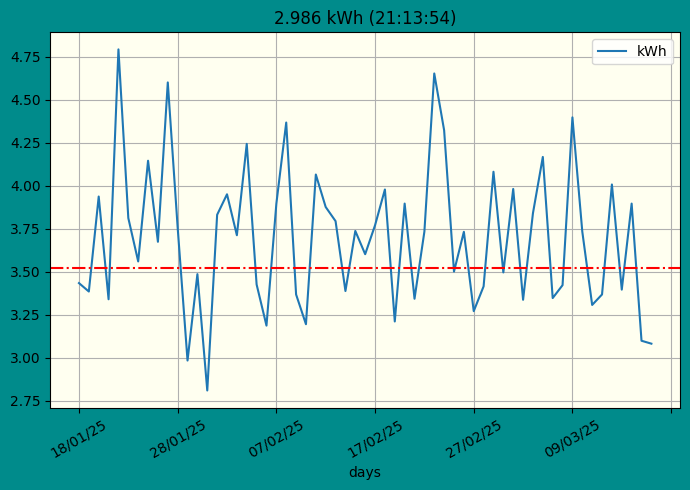

In [72]:
# 2 last months
scan = 60
# pandas plot the day consos in the group
fig, ax = plt.subplots(facecolor='darkcyan', figsize=(7, 5), layout='tight')  # as argument
#or fig.patch.set_facecolor('darkcyan') # This changes the grey to white
ax.set_facecolor("ivory")


df_grp.iloc[-scan:-1].plot(grid=True,ax=ax, y=["kWh"])   #df.plot(x="Name", y=["Age", "Height(in cm)"], kind="bar", ax=ax)
plt.title(str(last)+' kWh ('+str(here)+')')
plt.axhline(y=np.nanmean(df_grp),c='red', ls='-.')
plt.xticks(rotation=30);  # https://ipython.readthedocs.io/en/stable/interactive/tips.html


Text(0.5, 1.0, 'Variations journalières')

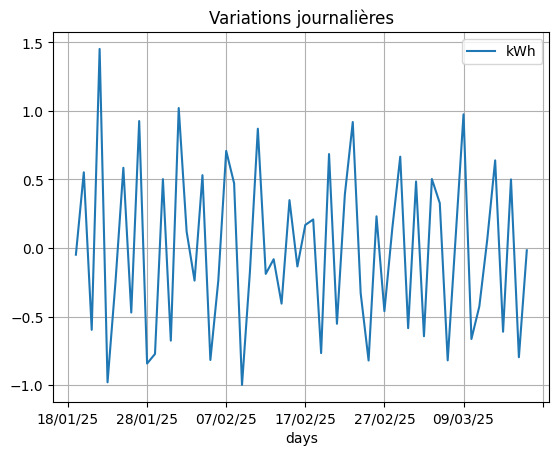

In [73]:
# variations journalières sur 60 jours
df_grp.iloc[-60:-1].diff().plot(grid=True)
plt.title('Variations journalières')

In [74]:
end = time.time()
print(end - start)

56.528058767318726


# Data from 21/08/23

In [75]:
# add hours column for conso_data (from 21/08/2023)
conso_days = conso_data.copy()
conso_days['hours']= conso_days['dates'].dt.strftime('%H')

conso_days['months']= conso_days['dates'].dt.strftime('%Y-%m')
conso_days['day']= conso_days['dates'].dt.strftime('%d')
conso_days

,Interval,kWh,sec,Wh,cumul(ms),dates,days,hours,months,day
0,21934,0.16,21.934,164.128750,21934,2023-08-21 21:38:49.634217,21/08/23,21,2023-08,21
1,21858,0.16,21.858,164.699424,43792,2023-08-21 21:39:11.492217,21/08/23,21,2023-08,21
2,22001,0.16,22.001,163.628926,65793,2023-08-21 21:39:33.493217,21/08/23,21,2023-08,21
3,21928,0.16,21.928,164.173659,87721,2023-08-21 21:39:55.421217,21/08/23,21,2023-08,21
4,21891,0.16,21.891,164.451144,109612,2023-08-21 21:40:17.312217,21/08/23,21,2023-08,21
...,...,...,...,...,...,...,...,...,...,...
2030153,21066,0.17,21.066,170.891484,49678402732,2025-03-18 21:11:50.432217,18/03/25,21,2025-03,18
2030154,20888,0.17,20.888,172.347759,49678423620,2025-03-18 21:12:11.320217,18/03/25,21,2025-03,18
2030155,21032,0.17,21.032,171.167744,49678444652,2025-03-18 21:12:32.352217,18/03/25,21,2025-03,18
2030156,21118,0.17,21.118,170.470689,49678465770,2025-03-18 21:12:53.470217,18/03/25,21,2025-03,18


In [76]:
end = time.time()
print(end - start)

150.2238450050354


In [77]:
conso_grouped_by_month = conso_days[['day','hours','months','kWh']].groupby('months', sort=False)

conso_grouped_by_month.groups.keys()

dict_keys(['2023-08', '2023-09', '2023-10', '2023-11', '2023-12', '2024-01', '2024-02', '2024-03', '2024-04', '2024-05', '2024-06', '2024-07', '2024-08', '2024-09', '2024-10', '2024-11', '2024-12', '2025-01', '2025-02', '2025-03'])

# define month to show

In [78]:
month=conso_grouped_by_month.get_group('2025-02')

In [79]:
conso_grouped_by_month_day = month.groupby(['day'], sort=False)

<Axes: xlabel='day'>

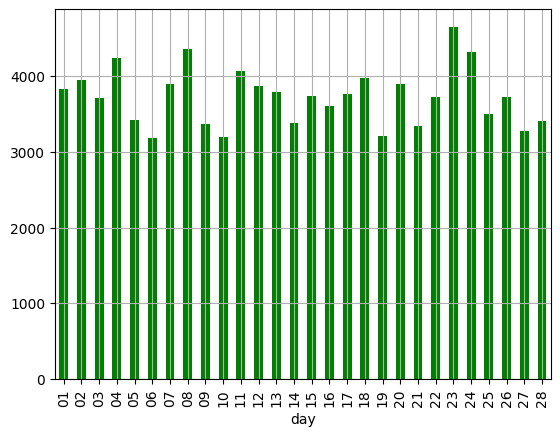

In [80]:
conso_grouped_by_month_day['kWh'].count().plot(grid=True,kind='bar',color='green',width=.5)

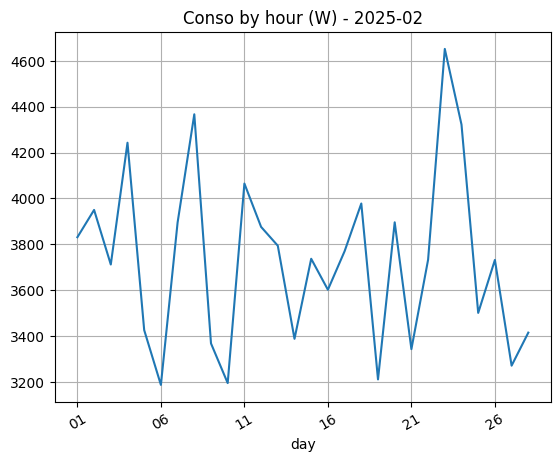

In [81]:
conso_grouped_by_month_day['hours'].count().plot(grid=True)#, kind='bar', color='green', width=.8)
plt.title('Conso by hour (W) - '+month.iloc[0]['months'])
plt.xticks(rotation=30);


In [82]:
conso_grouped_by_month_and_day = conso_days[['day','hours','months','kWh']].groupby(['months','day'], sort=False)

In [83]:
conso_grouped_by_month_day.count()

,hours,months,kWh
day,,,
01,3831,3831,3831
02,3950,3950,3950
03,3712,3712,3712
04,4243,4243,4243
05,3426,3426,3426
06,3187,3187,3187
07,3895,3895,3895
08,4367,4367,4367
09,3368,3368,3368


In [84]:
# Example: Get data for January 2025 at hour '00'
#group = conso_grouped_by_month_and_day.get_group('2025-01')
#group

In [85]:
# group.plot(grid=True, kind='bar', color='green', width=.8)
# plt.title('Conso by hour (W) - 2025-01')
# plt.xticks(rotation=30);


In [86]:
# conso total par mois
conso_grouped_by_month.count()


,day,hours,kWh
months,,,
2023-08,38404,38404,38404
2023-09,116331,116331,116331
2023-10,112859,112859,112859
2023-11,113611,113611,113611
2023-12,123298,123298,123298
2024-01,119520,119520,119520
2024-02,108757,108757,108757
2024-03,114275,114275,114275
2024-04,109932,109932,109932


In [87]:
# example groupby with apply
df = pd.DataFrame({'Animal': ['Falcon', 'Falcon',
                              'Parrot', 'Parrot'],
                   'Max Speed': [380., 370., 24., 26.]})
df.groupby("Animal", group_keys=True)[['Max Speed']].apply(lambda x: x)
      

Max Speed
Animal             
Falcon 0      380.0
       1      370.0
Parrot 2       24.0
       3       26.0

In [88]:
# import pandas as pd
# df = pd.read_csv(r'../csv/only-bh-extreme-events-satellite.csv'
#                   ,index_col=[0,1,2,3,4]
#                   ,header=[0,1,2,3]
#                   ,skipinitialspace=True
#                   #,tupleize_cols=True
#                 ) 

# df.columns = pd.MultiIndex.from_tuples(df.columns)
# df.index.names
# index=df.columns.levels[0]
# index
# df_des = pd.DataFrame(
#                             index=df.columns.levels[0],
#                             columns=['count','mean','std','min','25','50','75','max']
#                          )
# df_des

In [89]:
groupallbyday = conso_days[['days','hours','kWh']].groupby(['days'], sort=False)
groupallbyday[['kWh']].count()  #.apply(lambda x: x))

,kWh
days,
21/08/23,499
22/08/23,3699
23/08/23,4243
24/08/23,3687
25/08/23,3911
...,...
14/03/25,3396
15/03/25,3896
16/03/25,3099


In [90]:
conso_days

,Interval,kWh,sec,Wh,cumul(ms),dates,days,hours,months,day
0,21934,0.16,21.934,164.128750,21934,2023-08-21 21:38:49.634217,21/08/23,21,2023-08,21
1,21858,0.16,21.858,164.699424,43792,2023-08-21 21:39:11.492217,21/08/23,21,2023-08,21
2,22001,0.16,22.001,163.628926,65793,2023-08-21 21:39:33.493217,21/08/23,21,2023-08,21
3,21928,0.16,21.928,164.173659,87721,2023-08-21 21:39:55.421217,21/08/23,21,2023-08,21
4,21891,0.16,21.891,164.451144,109612,2023-08-21 21:40:17.312217,21/08/23,21,2023-08,21
...,...,...,...,...,...,...,...,...,...,...
2030153,21066,0.17,21.066,170.891484,49678402732,2025-03-18 21:11:50.432217,18/03/25,21,2025-03,18
2030154,20888,0.17,20.888,172.347759,49678423620,2025-03-18 21:12:11.320217,18/03/25,21,2025-03,18
2030155,21032,0.17,21.032,171.167744,49678444652,2025-03-18 21:12:32.352217,18/03/25,21,2025-03,18
2030156,21118,0.17,21.118,170.470689,49678465770,2025-03-18 21:12:53.470217,18/03/25,21,2025-03,18


In [91]:

# group all by day for all conso_days
groupallbydayhours = conso_days[['days','hours','kWh']].groupby(['days','hours'], sort=False)
# use apply to show the group
groupallbydayhours[['days','hours','kWh']].apply(lambda x: x)


days hours   kWh
days     hours                              
21/08/23 21    0        21/08/23    21  0.16
               1        21/08/23    21  0.16
               2        21/08/23    21  0.16
               3        21/08/23    21  0.16
               4        21/08/23    21  0.16
...                          ...   ...   ...
18/03/25 21    2030153  18/03/25    21  0.17
               2030154  18/03/25    21  0.17
               2030155  18/03/25    21  0.17
               2030156  18/03/25    21  0.17
               2030157  18/03/25    21  0.17

[2030158 rows x 3 columns]

In [92]:
groupallbyday.indices.keys()

dict_keys(['21/08/23', '22/08/23', '23/08/23', '24/08/23', '25/08/23', '26/08/23', '27/08/23', '28/08/23', '29/08/23', '30/08/23', '31/08/23', '01/09/23', '02/09/23', '03/09/23', '04/09/23', '05/09/23', '06/09/23', '07/09/23', '08/09/23', '09/09/23', '10/09/23', '11/09/23', '12/09/23', '13/09/23', '14/09/23', '15/09/23', '16/09/23', '17/09/23', '18/09/23', '19/09/23', '20/09/23', '21/09/23', '22/09/23', '23/09/23', '24/09/23', '25/09/23', '26/09/23', '27/09/23', '28/09/23', '29/09/23', '30/09/23', '01/10/23', '02/10/23', '03/10/23', '04/10/23', '05/10/23', '06/10/23', '07/10/23', '08/10/23', '09/10/23', '10/10/23', '11/10/23', '12/10/23', '13/10/23', '14/10/23', '15/10/23', '16/10/23', '17/10/23', '18/10/23', '19/10/23', '20/10/23', '21/10/23', '22/10/23', '23/10/23', '24/10/23', '25/10/23', '26/10/23', '27/10/23', '28/10/23', '29/10/23', '30/10/23', '31/10/23', '01/11/23', '02/11/23', '03/11/23', '04/11/23', '05/11/23', '06/11/23', '07/11/23', '08/11/23', '09/11/23', '10/11/23', '11/1

In [93]:
groupallbydayhours.indices.keys()

dict_keys([('21/08/23', '21'), ('21/08/23', '22'), ('21/08/23', '23'), ('22/08/23', '21'), ('22/08/23', '22'), ('22/08/23', '23'), ('22/08/23', '00'), ('22/08/23', '01'), ('22/08/23', '02'), ('22/08/23', '03'), ('22/08/23', '04'), ('22/08/23', '05'), ('22/08/23', '06'), ('22/08/23', '07'), ('22/08/23', '08'), ('22/08/23', '09'), ('22/08/23', '10'), ('22/08/23', '11'), ('22/08/23', '12'), ('22/08/23', '13'), ('22/08/23', '14'), ('22/08/23', '15'), ('22/08/23', '16'), ('22/08/23', '17'), ('22/08/23', '18'), ('22/08/23', '19'), ('22/08/23', '20'), ('23/08/23', '21'), ('23/08/23', '22'), ('23/08/23', '23'), ('23/08/23', '00'), ('23/08/23', '01'), ('23/08/23', '02'), ('23/08/23', '03'), ('23/08/23', '04'), ('23/08/23', '05'), ('23/08/23', '06'), ('23/08/23', '07'), ('23/08/23', '08'), ('23/08/23', '09'), ('23/08/23', '10'), ('23/08/23', '11'), ('23/08/23', '12'), ('23/08/23', '13'), ('23/08/23', '14'), ('23/08/23', '15'), ('23/08/23', '16'), ('23/08/23', '17'), ('23/08/23', '18'), ('23/08/2

In [94]:
grp_by_day = groupallbyday.count()
grp_by_day

,hours,kWh
days,,
21/08/23,499,499
22/08/23,3699,3699
23/08/23,4243,4243
24/08/23,3687,3687
25/08/23,3911,3911
...,...,...
14/03/25,3396,3396
15/03/25,3896,3896
16/03/25,3099,3099


In [95]:
grp_by_day['kWh'].cumsum()

days
21/08/23        499
22/08/23       4198
23/08/23       8441
24/08/23      12128
25/08/23      16039
             ...   
14/03/25    2017095
15/03/25    2020991
16/03/25    2024090
17/03/25    2027172
18/03/25    2030158
Name: kWh, Length: 576, dtype: int64

In [96]:
grp_by_dayhours = groupallbydayhours.count()
grp_by_dayhours

kWh
days     hours     
21/08/23 21      58
         22     278
         23     163
22/08/23 00     133
         01     133
...             ...
18/03/25 17     118
         18     119
         19     174
         20     176
         21      37

[13801 rows x 1 columns]

In [97]:
grp_by_dayhours['kWh'].cumsum()

days      hours
21/08/23  21            58
          22           336
          23           499
22/08/23  00           632
          01           765
                    ...   
18/03/25  17       2029652
          18       2029771
          19       2029945
          20       2030121
          21       2030158
Name: kWh, Length: 13801, dtype: int64

In [98]:
grp_by_dayhours['cumsum'] = grp_by_dayhours.groupby(level=0)['kWh'].cumsum()
grp_by_dayhours['diff'] = grp_by_dayhours.groupby(level=0)['kWh'].diff()
# or
grp_by_dayhours['cumsum'] = grp_by_dayhours.groupby(['days'])['kWh'].cumsum()
grp_by_dayhours['diff'] = grp_by_dayhours.groupby(['days'])['kWh'].diff()
grp_by_dayhours

kWh  cumsum   diff
days     hours                    
21/08/23 21      58      58    NaN
         22     278     336  220.0
         23     163     499 -115.0
22/08/23 00     133     133    NaN
         01     133     266    0.0
...             ...     ...    ...
18/03/25 17     118    2480   19.0
         18     119    2599    1.0
         19     174    2773   55.0
         20     176    2949    2.0
         21      37    2986 -139.0

[13801 rows x 3 columns]

In [99]:
today, grp_by_dayhours.loc[today]

('18/03/25',
        kWh  cumsum   diff
 hours                    
 00     142     142    NaN
 01     125     267  -17.0
 02     122     389   -3.0
 03     113     502   -9.0
 04     101     603  -12.0
 05     107     710    6.0
 06     107     817    0.0
 07      93     910  -14.0
 08     105    1015   12.0
 09     105    1120    0.0
 10     177    1297   72.0
 11     125    1422  -52.0
 12     137    1559   12.0
 13     418    1977  281.0
 14     178    2155 -240.0
 15     108    2263  -70.0
 16      99    2362   -9.0
 17     118    2480   19.0
 18     119    2599    1.0
 19     174    2773   55.0
 20     176    2949    2.0
 21      37    2986 -139.0)

Text(0.5, 1.0, 'Cumul journalier')

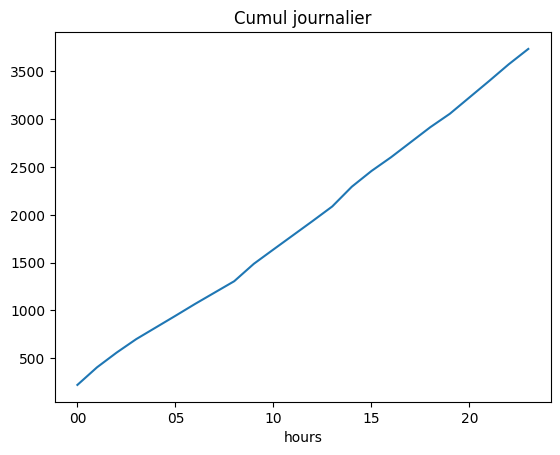

In [100]:
# progression sans surprise
grp_by_dayhours.loc['26/08/24']['cumsum'].plot()
plt.title('Cumul journalier')

Text(0.5, 1.0, 'Variation horaire')

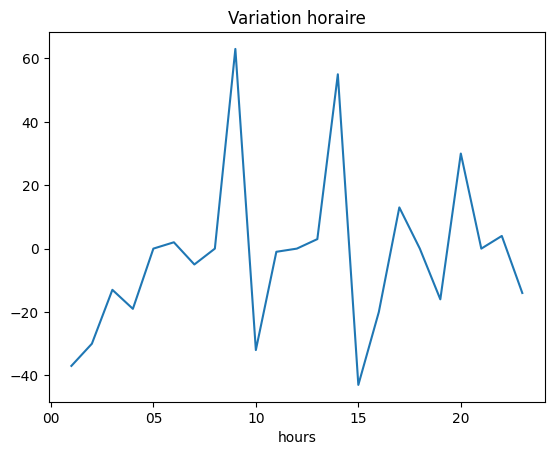

In [101]:
# plus parlant
grp_by_dayhours.loc['26/08/24']['diff'].plot()
plt.title(r'Variation horaire')

In [102]:
# count number of days since 21/08/2023
# https://stackoverflow.com/questions/45972388/count-my-multi-index-length-in-a-dataframe-pandas
n = len(grp_by_dayhours.index.levels[0].unique())
# or
n = len(grp_by_dayhours.index.levels[0])
# or
n = grp_by_dayhours.index.levshape[0]  # levshape -> (371,24)
n

576

In [103]:
df_grp.tail(n)['kWh'].describe()


count    576.000000
mean       3.524580
std        0.659171
min        0.499000
25%        3.345250
50%        3.620500
75%        3.895250
max        4.956000
Name: kWh, dtype: float64

In [104]:
maxday = df_grp.tail(n)['kWh'].idxmax()

Text(0.5, 1.0, '576 days')

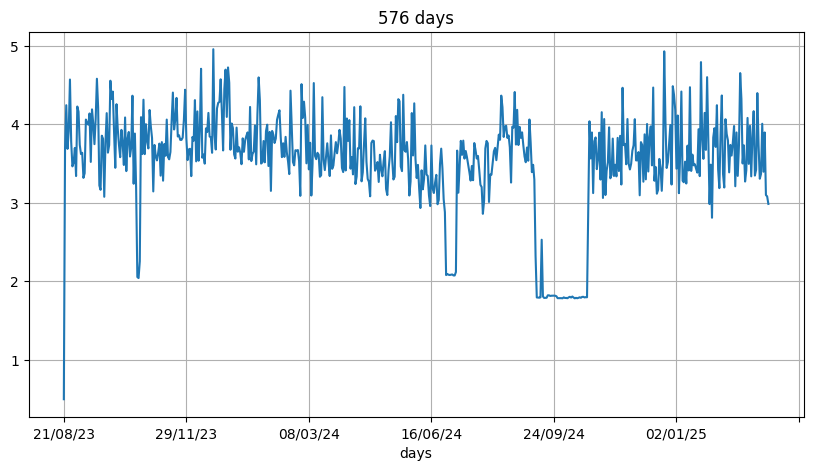

In [105]:
# show conso in span 
span = n
df_grp.tail(span)['kWh'].plot(figsize=(10, 5), layout='tight', grid=True)
plt.title(f'{span} days')

Text(0.5, 1.0, '400 days')

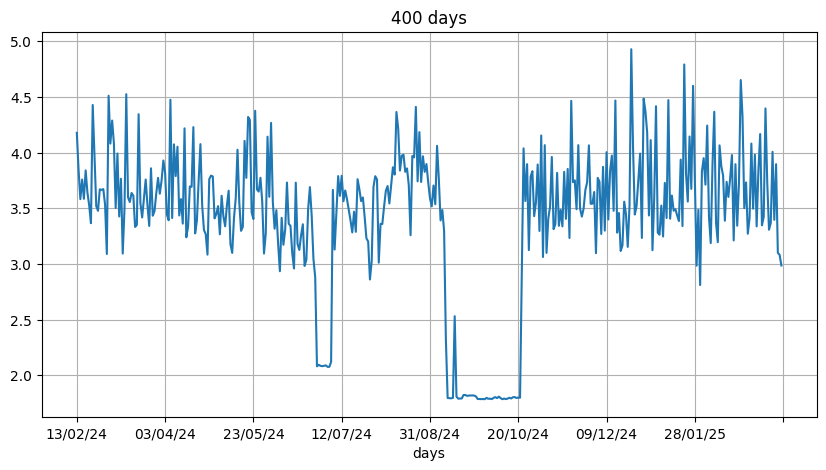

In [106]:
# show conso in span 
span = 400
df_grp.tail(span)['kWh'].plot(figsize=(10, 5), layout='tight', grid=True)
plt.title(f'{span} days')

In [107]:
df_grp['kWh']

days
21/08/23    0.499
22/08/23    3.699
23/08/23    4.243
24/08/23    3.687
25/08/23    3.911
            ...  
14/03/25    3.396
15/03/25    3.896
16/03/25    3.099
17/03/25    3.082
18/03/25    2.986
Name: kWh, Length: 576, dtype: float64

In [108]:
df_grp.describe()

,kWh
count,576.000000
mean,3.524580
std,0.659171
min,0.499000
25%,3.345250
50%,3.620500
75%,3.895250
max,4.956000


array([[<Axes: title={'center': 'kWh'}>]], dtype=object)

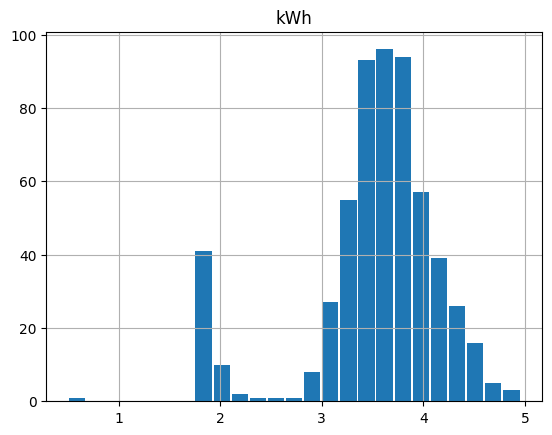

In [109]:
# répartition des consos de 1 à 5 kWh par jour
# https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.hist.html
# histtype{'bar', 'barstacked', 'step', 'stepfilled'}, default: 'bar'
df_grp.hist(bins=25, density=False, histtype='bar',rwidth=0.9, align='mid')

In [110]:
df_grp.tail(span)['kWh']

days
13/02/24    4.178
14/02/24    3.842
15/02/24    3.582
16/02/24    3.758
17/02/24    3.585
            ...  
14/03/25    3.396
15/03/25    3.896
16/03/25    3.099
17/03/25    3.082
18/03/25    2.986
Name: kWh, Length: 400, dtype: float64

# Conso par heure

In [111]:
day

'18/03/25'

In [112]:
grp_by_dayhours.loc[day]

,kWh,cumsum,diff
hours,,,
00,142,142,NaN
01,125,267,-17.0
02,122,389,-3.0
03,113,502,-9.0
04,101,603,-12.0
05,107,710,6.0
06,107,817,0.0
07,93,910,-14.0
08,105,1015,12.0


In [113]:
# select a day to plot
day = '02/07/24'
day = today
len(grp_by_dayhours.loc[day])


22

In [114]:
l = range(1,len(grp_by_dayhours.loc[day])+1)
l

range(1, 23)

In [115]:
grp_by_dayhours.loc[day,'days'] = l #ist(1,len(grp_by_day.loc[day])+1)

In [116]:
grp_by_dayhours.loc[day,'days'].values

array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
       14., 15., 16., 17., 18., 19., 20., 21., 22.])

In [117]:
grp_by_dayhours.loc[day,'days']

hours
00     1.0
01     2.0
02     3.0
03     4.0
04     5.0
05     6.0
06     7.0
07     8.0
08     9.0
09    10.0
10    11.0
11    12.0
12    13.0
13    14.0
14    15.0
15    16.0
16    17.0
17    18.0
18    19.0
19    20.0
20    21.0
21    22.0
Name: days, dtype: float64

In [118]:
### ????????????????????????
grp_by_dayhours.loc[day,'days'] = grp_by_dayhours.loc[day,'days'].values.astype('int64')

In [119]:
grp_by_dayhours.loc[day].info()

<class 'pandas.core.frame.DataFrame'>
Index: 22 entries, 00 to 21
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   kWh     22 non-null     int64  
 1   cumsum  22 non-null     int64  
 2   diff    21 non-null     float64
 3   days    22 non-null     float64
dtypes: float64(2), int64(2)
memory usage: 880.0+ bytes


In [120]:
grp_by_dayhours.loc[day,'days']

hours
00     1.0
01     2.0
02     3.0
03     4.0
04     5.0
05     6.0
06     7.0
07     8.0
08     9.0
09    10.0
10    11.0
11    12.0
12    13.0
13    14.0
14    15.0
15    16.0
16    17.0
17    18.0
18    19.0
19    20.0
20    21.0
21    22.0
Name: days, dtype: float64

In [121]:
day

'18/03/25'

In [122]:
grp_by_dayhours.loc[day]

,kWh,cumsum,diff,days
hours,,,,
00,142,142,NaN,1.0
01,125,267,-17.0,2.0
02,122,389,-3.0,3.0
03,113,502,-9.0,4.0
04,101,603,-12.0,5.0
05,107,710,6.0,6.0
06,107,817,0.0,7.0
07,93,910,-14.0,8.0
08,105,1015,12.0,9.0


Text(0.5, 1.0, '18/03/25')

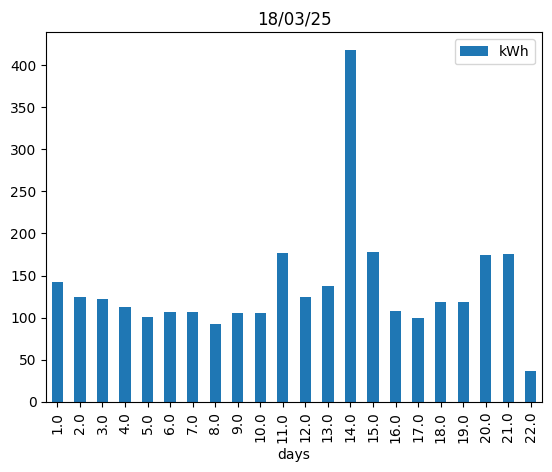

In [123]:
grp_by_dayhours.loc[day][['days','kWh']].plot.bar(x='days')
plt.title(f'{day}')

In [124]:
grp_by_dayhours.loc[day].index

Index(['00', '01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11',
       '12', '13', '14', '15', '16', '17', '18', '19', '20', '21'],
      dtype='object', name='hours')

# Conso du jour


In [125]:

grp_by_dayhours.count()

kWh       13801
cumsum    13801
diff      13225
days         22
dtype: int64

In [126]:
day = '09/09/24'
day = maxday
#day = today
grp_by_dayhours.loc[day].kWh

hours
00    151
01    166
02    150
03    168
04    167
05    151
06    166
07    146
08    122
09    130
10    115
11    130
12    130
13    115
14    130
15    181
16    156
17    154
18    944
19    187
20    281
21    311
22    301
23    304
Name: kWh, dtype: int64

In [127]:
def conso_by_hour(day):
    global data
    # conso by hour
    #data = groupedbyhour.count().kWh
    data = grp_by_dayhours.loc[day].kWh

    # len(groupedbyhour)
    x = np.arange(1,len(data)+1)
    ymax = max(data)+5
    #groupedbyhour.count().plot(grid=True,xticks=x)
    fig, ax = plt.subplots(figsize=(8, 5), facecolor='darkcyan')

    plt.bar(x,data)
    #plt.grid()
    plt.tight_layout()
    plt.title(f'Conso by hour (W) {day} - Total {sum(data)}')
    plt.xlim(0,len(x)+1)
    #plt.xticks(rotation=30);
    #plt.ylim(0,ymax)

    rects = ax.patches

    # Make some labels.
    labels = [f"{i}" for i in data]
    fontfamily = {'calibri', 'serif', 'sans-serif', 'cursive', 'fantasy', 'monospace'}
    for rect, label in zip(rects, labels):
        height = rect.get_height()
        ax.text(
            rect.get_x() + rect.get_width() / 2, height + 3, label, ha="center", va="bottom",
            fontfamily=fontfamily, fontsize=10, fontweight='bold', color='red'
        )


# 100 days

            kWh
days           
18/03/25  2.986


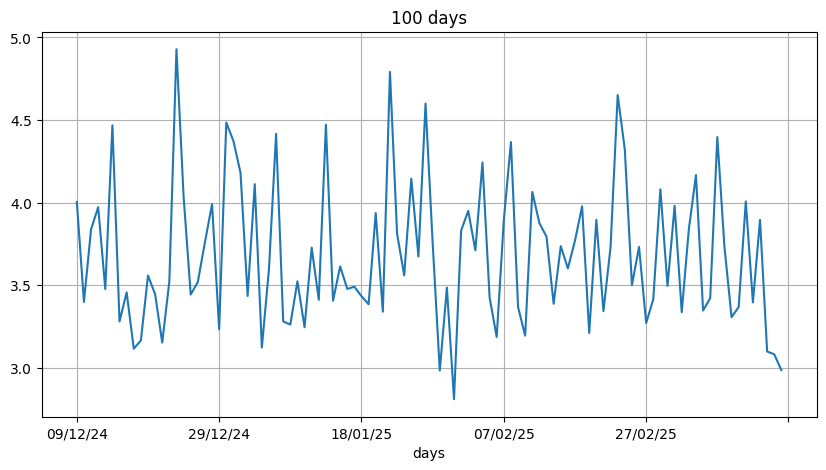

In [128]:
# show conso in span 
span = 100
df_grp.tail(span)['kWh'].plot(figsize=(10, 5), layout='tight', grid=True)
plt.title(f'{span} days')
sum(df_grp.tail(span)['kWh'])
print(df_grp.tail(1))

In [129]:
#import timeit
#start = timeit.timeit()
#print("hello")
end = time.time()
print(end - start)

197.1942527294159


# Today

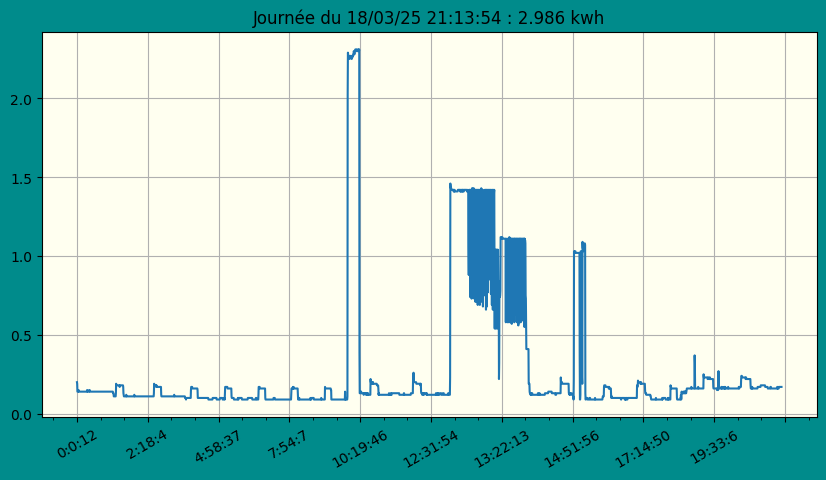

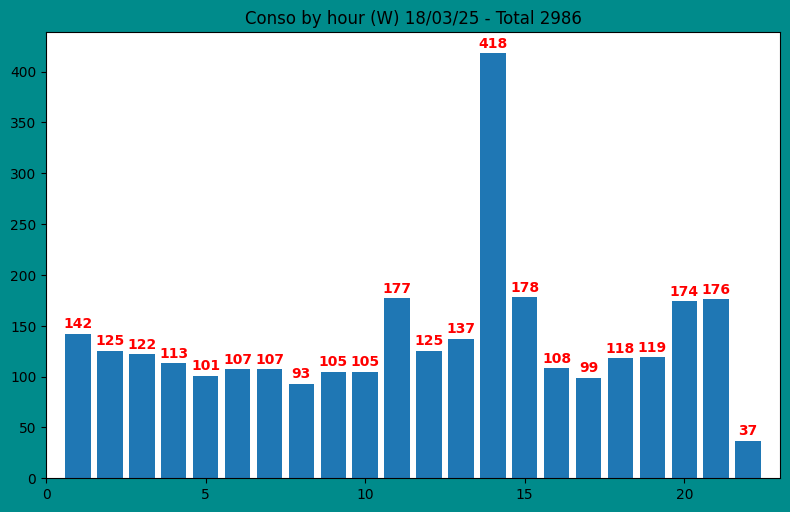

In [130]:
show(today,bgcolor='ivory')
conso_by_hour(today)

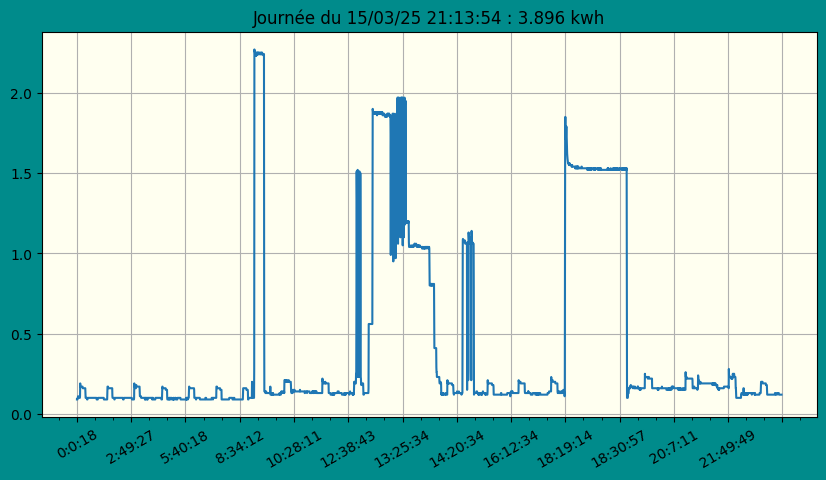

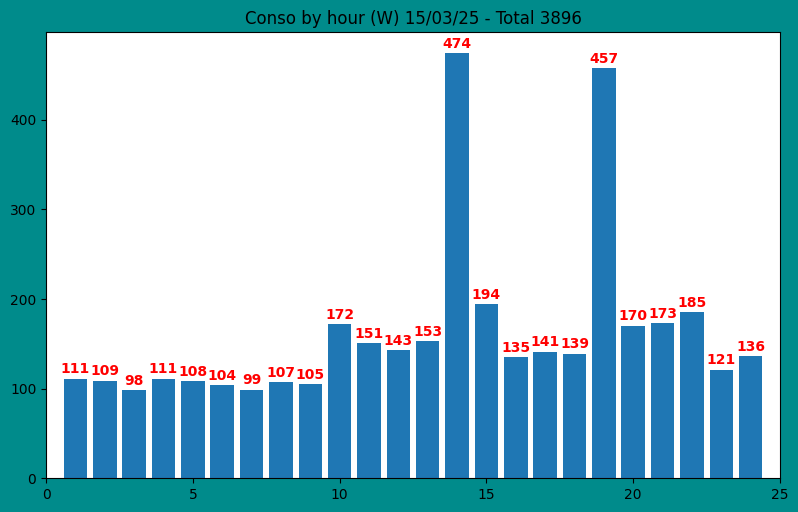

In [131]:
day = '15/03/25'
day, show(day,bgcolor='ivory')
conso_by_hour(day)

21/12/23


(None, 4956)

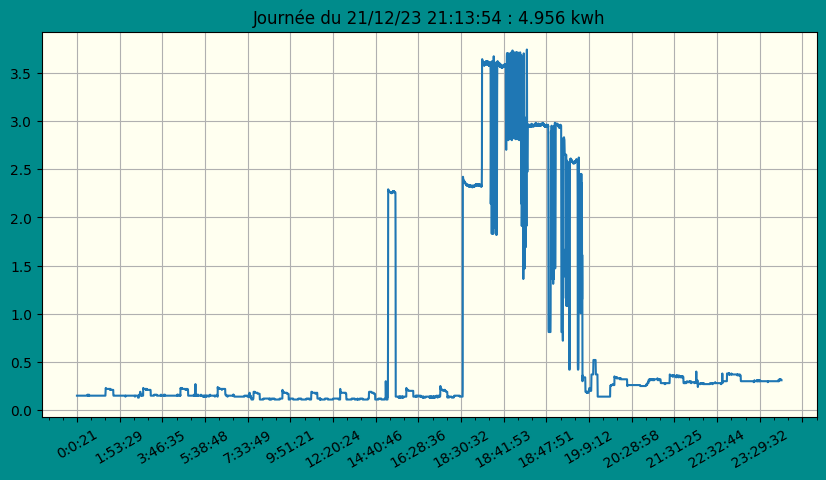

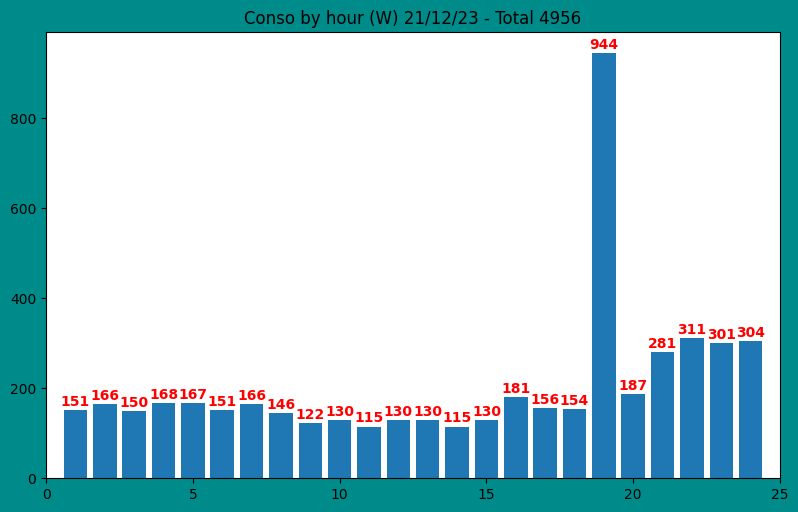

In [132]:
print(maxday)
# retour vietnam 22/10/2024
#day = '22/10/24'
day = maxday
day, show(day,bgcolor='ivory')
conso_by_hour(day),sum(data)

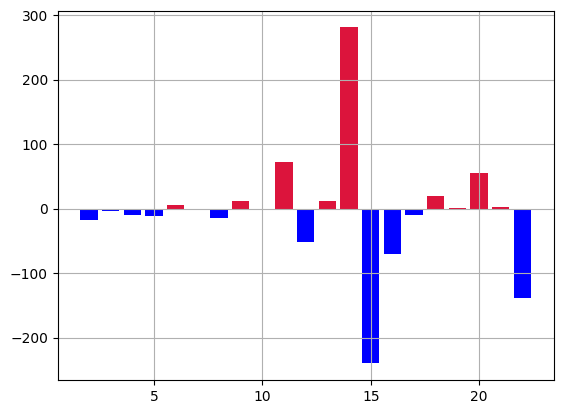

In [133]:
diff = grp_by_dayhours.loc[today]
diff

x = np.arange(1,len(diff)+1)

plt.bar(x,diff['diff'], color=np.where(diff['diff'] > 0, 'crimson', 'blue'))
plt.grid()

<Axes: xlabel='hours'>

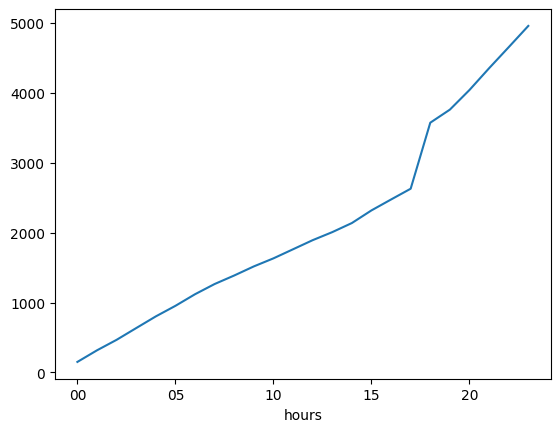

In [134]:
data.cumsum().plot()


<Axes: xlabel='hours'>

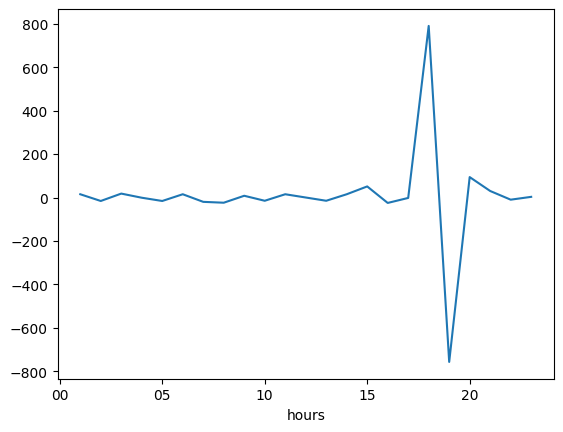

In [135]:
# evolution par heure
data.diff().plot()

In [136]:
data.diff().describe()

count     23.000000
mean       6.652174
std      234.756471
min     -757.000000
25%      -15.500000
50%        0.000000
75%       15.000000
max      790.000000
Name: kWh, dtype: float64

<Axes: >

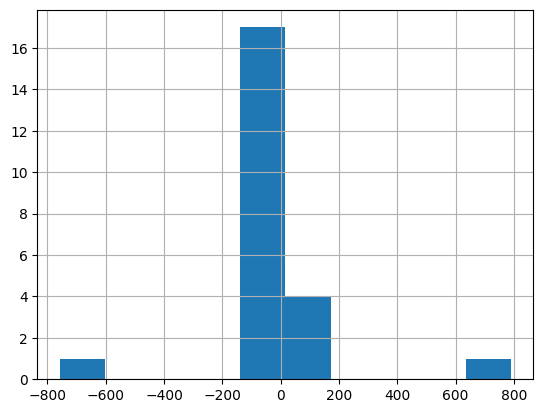

In [137]:
data.diff().hist()

# Test sauvegarde

# list files in current directory


In [138]:
import os
os.listdir(path='.')

['.git',
 '.gitignore',
 '.git_old',
 '.ipynb_checkpoints',
 '1row.flf',
 '5_days_meteo.ipynb',
 '8days.csv',
 '8days.pkl',
 '8days_dump.json',
 '8days_to_json.json',
 'advanced_expression.ipynb',
 'alphabeta_tree.ipynb',
 'amlich.ipynb',
 'amlich5.ipynb',
 'amlich5_test.ipynb',
 'amlich_data.py',
 'amlich_functions.py',
 'amlich_lib.py',
 'amlich_soc_tiet.ipynb',
 'AntPath.ipynb',
 'Apple.csv',
 'astronomie_def.ipynb',
 'atom_electronic_configuration.ipynb',
 'average_binding_energy_by_nucleons.ipynb',
 'bar_label.ipynb',
 'bell_curve.ipynb',
 'bitcoin_api.ipynb',
 'bitmap_convert.ipynb',
 'bitmap_structure.ipynb',
 'CAC40.csv',
 'chess_board.ipynb',
 'coindesk_api_client.ipynb',
 'collections.ipynb',
 'colormaps.ipynb',
 'conso.txt',
 'conso_by_hour.ipynb',
 'conso_data.csv',
 'conso_day_from_20230821.csv',
 'conso_jour.csv',
 'conso_jour.png',
 'conso_kwh.ipynb',
 'conso_kwh_mini.ipynb',
 'conso_kwh_reduced.ipynb',
 'conso_par_jour.csv',
 'covid19_france.ipynb',
 'cryptography_ferne

# list store files csv


In [139]:
res = []
# Iterate directory
for file in os.listdir('.'):
    # check only text files
    if file.endswith('.csv'):
        res.append(file)
        print(file)
#print(res)

8days.csv
Apple.csv
CAC40.csv
conso_data.csv
conso_day_from_20230821.csv
conso_jour.csv
conso_par_jour.csv
data_temp16122022.csv
demain.csv
df.csv
df_grp.csv
DowJones.csv
EURUSD.csv
Ford.csv
karaoke.csv
ligue1_2020_27.csv
Nasdaq.csv
Nikkei.csv
planete.csv
saturn_bodies.csv
saturn_rings.csv
SMSSpamCollection.csv
table-indicateurs-open-data-dep-2023-06-30-17h59.csv
table-indicateurs-open-data-france-2023-06-30-17h59.csv
temp_humidity.csv
Tesla.csv
titanic.csv
Toyota.csv
VNDUSD.csv
WA_Fn-UseC_-Telco-Customer-Churn.csv
week.csv


('21/12/23', None)

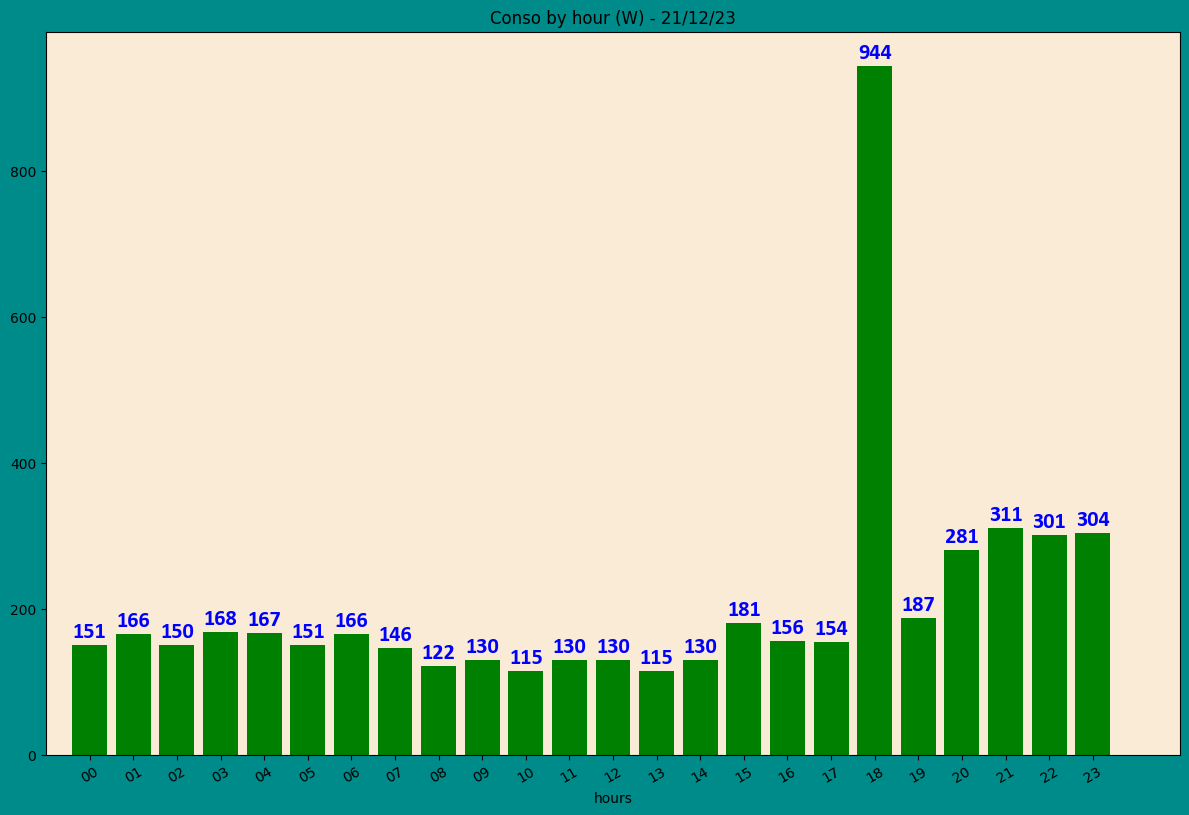

In [140]:
day,conso_byhour(day)

In [141]:
# save to file
import pickle
path = r'../consobyhour.pkl'
with open(path,'wb') as file:
    pickle.dump(data, file)

# plot any day


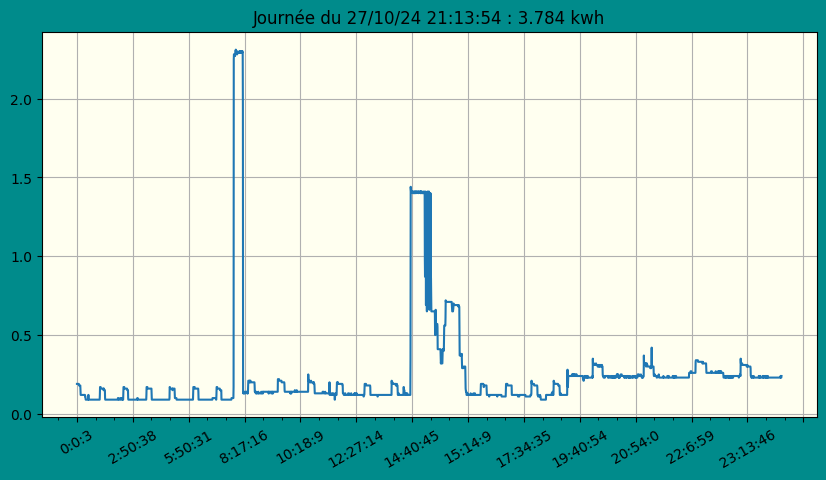

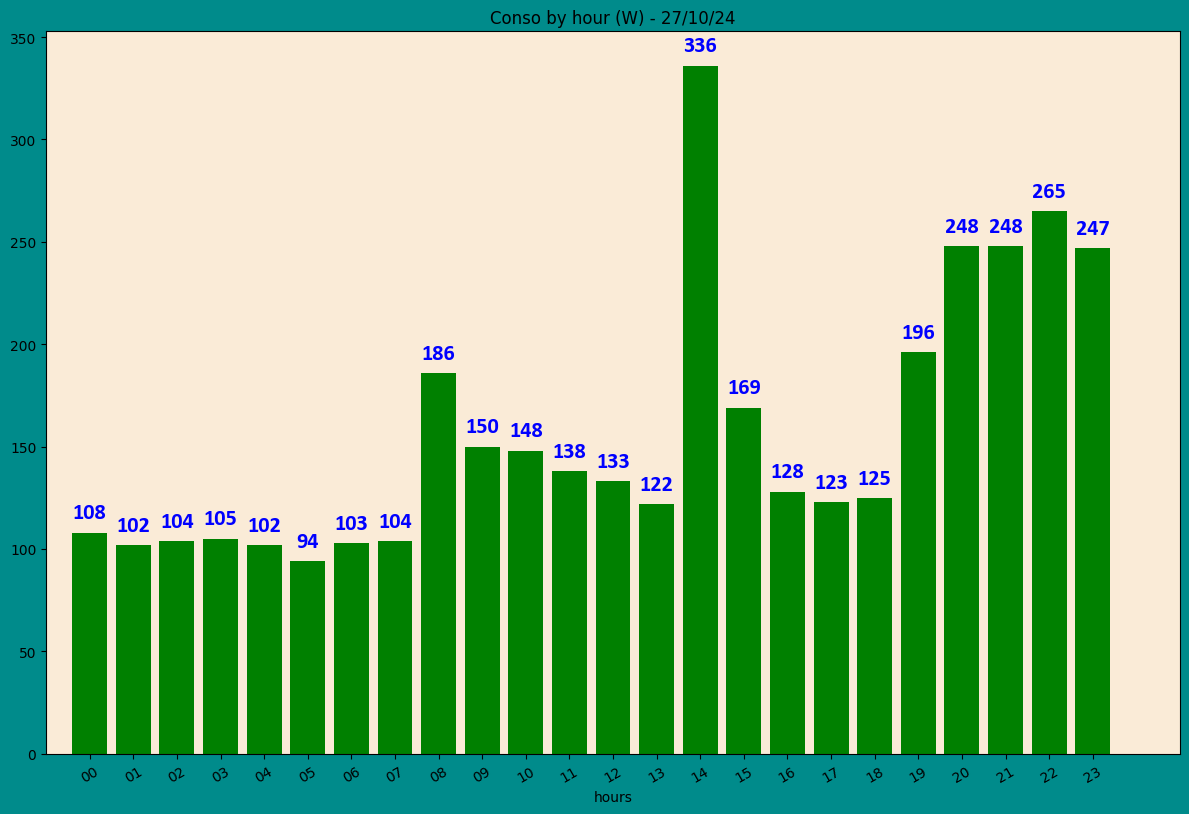

In [142]:
day = '27/10/24'
#day = today
show(day,pltcolor='darkcyan')
conso_byhour(day)

In [143]:
month

,day,hours,months,kWh
1860756,01,00,2025-02,0.23
1860757,01,00,2025-02,0.23
1860758,01,00,2025-02,0.23
1860759,01,00,2025-02,0.23
1860760,01,00,2025-02,0.22
...,...,...,...,...
1965211,28,23,2025-02,0.11
1965212,28,23,2025-02,0.11
1965213,28,23,2025-02,0.10
1965214,28,23,2025-02,0.10


In [144]:
month.describe()


,kWh
count,104460.000000
mean,0.334575
std,0.555164
min,0.090000
25%,0.120000
50%,0.140000
75%,0.190000
max,3.650000


array([[<Axes: title={'center': 'kWh'}>]], dtype=object)

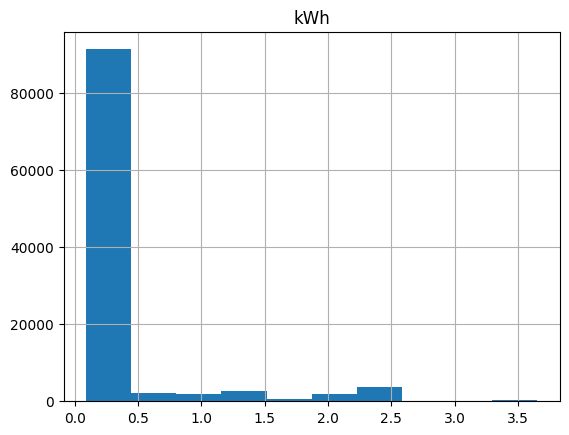

In [145]:
month.hist()

<Axes: >

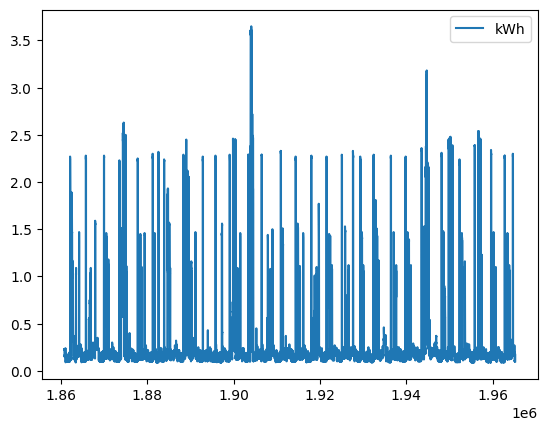

In [146]:
month.plot()

In [147]:
# index with max conso in this month
month.idxmax().kWh

1904079

In [148]:
# plot month day max conso (télévision de 11h à 23h)
day_idx = month.idxmax()
#day = '27/10/2024'
day_idx

day       1961801
hours     1864412
months    1860756
kWh       1904079
dtype: int64

In [149]:
#show(day,pltcolor='darkcyan')
#conso_byhour(day)

In [150]:
grp_by_dayhours

kWh  cumsum   diff  days
days     hours                          
21/08/23 21      58      58    NaN   NaN
         22     278     336  220.0   NaN
         23     163     499 -115.0   NaN
22/08/23 00     133     133    NaN   NaN
         01     133     266    0.0   NaN
...             ...     ...    ...   ...
18/03/25 17     118    2480   19.0  18.0
         18     119    2599    1.0  19.0
         19     174    2773   55.0  20.0
         20     176    2949    2.0  21.0
         21      37    2986 -139.0  22.0

[13801 rows x 4 columns]

In [151]:
month

,day,hours,months,kWh
1860756,01,00,2025-02,0.23
1860757,01,00,2025-02,0.23
1860758,01,00,2025-02,0.23
1860759,01,00,2025-02,0.23
1860760,01,00,2025-02,0.22
...,...,...,...,...
1965211,28,23,2025-02,0.11
1965212,28,23,2025-02,0.11
1965213,28,23,2025-02,0.10
1965214,28,23,2025-02,0.10


In [152]:
month.idxmax()


day       1961801
hours     1864412
months    1860756
kWh       1904079
dtype: int64

In [153]:
month.loc[month.idxmax().kWh]


day            12
hours          13
months    2025-02
kWh          3.65
Name: 1904079, dtype: object

In [154]:
grp_by_dayhours.loc[['28/02/25']].kWh

days      hours
28/02/25  00       115
          01       111
          02        98
          03       110
          04       112
          05       110
          06        97
          07       110
          08       162
          09       143
          10       135
          11       147
          12       144
          13       200
          14       148
          15       184
          16       161
          17       147
          18       142
          19       169
          20       225
          21       174
          22       153
          23       118
Name: kWh, dtype: int64

In [155]:
max_hour = grp_by_dayhours.loc[['28/02/25']].kWh.idxmax()[1]
max_hour

'20'

<Axes: xlabel='days,hours'>

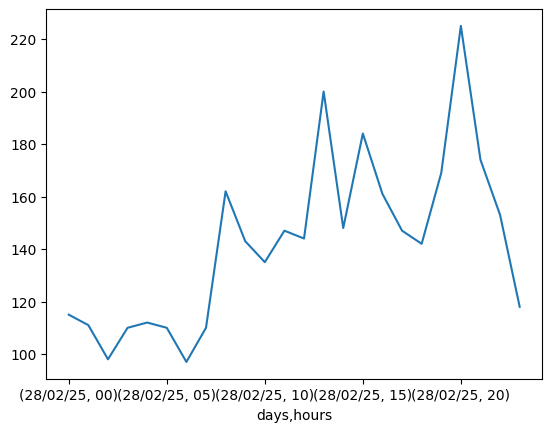

In [156]:
grp_by_dayhours.loc[['28/02/25']].kWh.plot()#.idxmax()

In [157]:
grp_by_dayhours.columns

Index(['kWh', 'cumsum', 'diff', 'days'], dtype='object')

In [158]:
# diff
# plt.plot(grp_by_dayhours.loc[month.idxmax()]['diff'],label=grp_by_dayhours.columns[2])
# plt.legend()

In [159]:
# cumsum
# plt.plot(grp_by_dayhours.loc[month.idxmax()]['cumsum'],label=grp_by_dayhours.columns[1])
# plt.legend()

In [160]:
# 41 s
# file to big to git sync

# create .gitignore
filename=r'../conso_data.csv'
#conso_data.to_csv(filename)
#43.6s size 140128 kB